In [1]:
import os
from tensorflow import keras
from methods.config import *
from methods.clean_data import Data_Prep
from methods.nn import get_NN_results
from methods.var import get_VAR_results
from methods.model_results import get_model_details, get_best_model_name
from methods.data_methods import prepare_model_data
from methods.plot import plot_variables, plot_results, cluster_columns
from methods.residual_bootstrap import get_prediction_intervals
import shap

d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Select Model

In [2]:
end_year = 2017 # Select from 2006, 2010, 2017 and 2019
variable = 'UNRATE' # Select from CPIAUCSL, GS5, RPI and UNRATE
output_steps = 1 # Select from 1, 4, 6, 12 and 24

# Vector Auto-Regression

In [3]:
data_prep = Data_Prep(DATA_PATH, TRANSFORM_PATH)
data_prep.transform_to_supervised_learning(NA_CUTOFF, TARGET_VARIABLES, output_steps = output_steps, start = f'{START_YEAR}-01-01', end = f'{end_year}-01-01')
var_dataset = data_prep.supervised_dataset
Var_results = get_VAR_results(var_dataset, test_steps = TEST_STEPS, val_steps = VAL_STEPS, output_steps = output_steps)

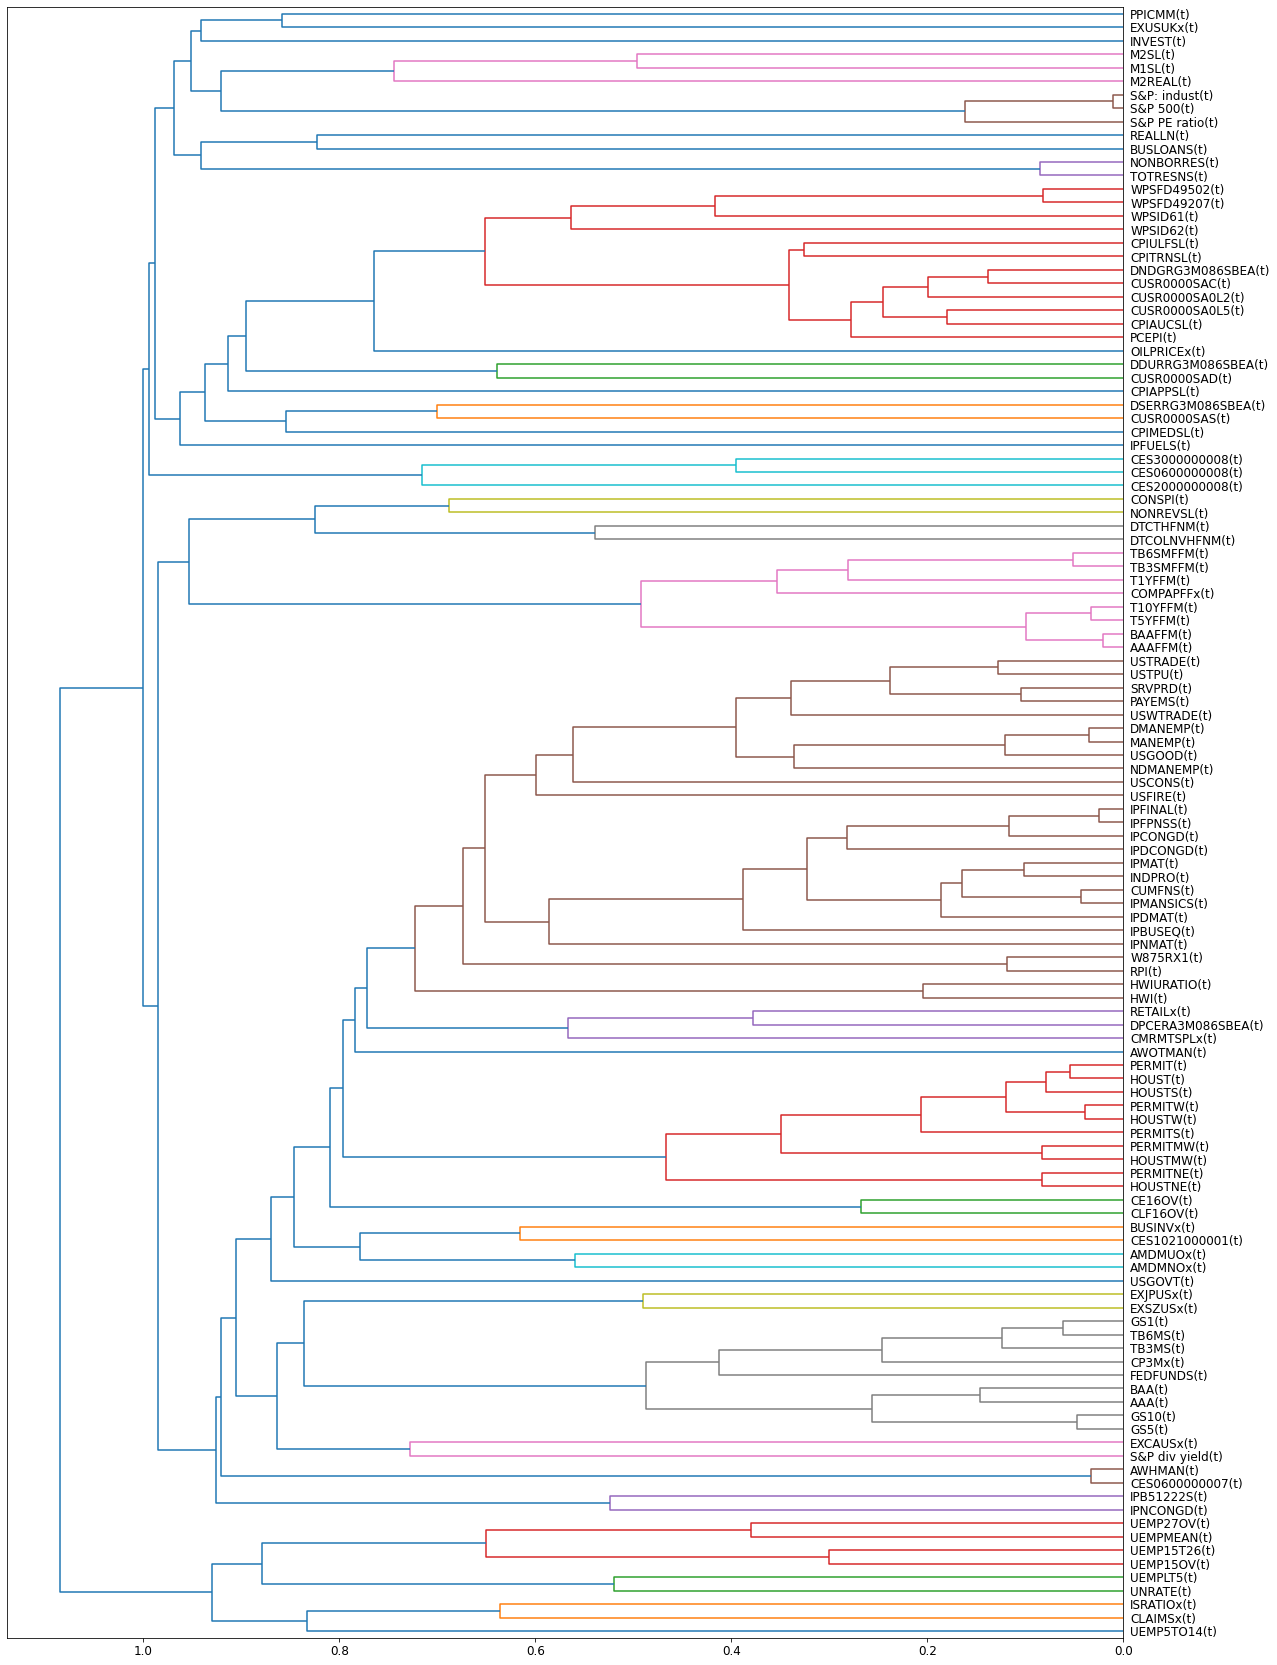

In [4]:
cluster_columns(var_dataset['transformed_data'][var_dataset['X_variables']], figsize=(20,30))

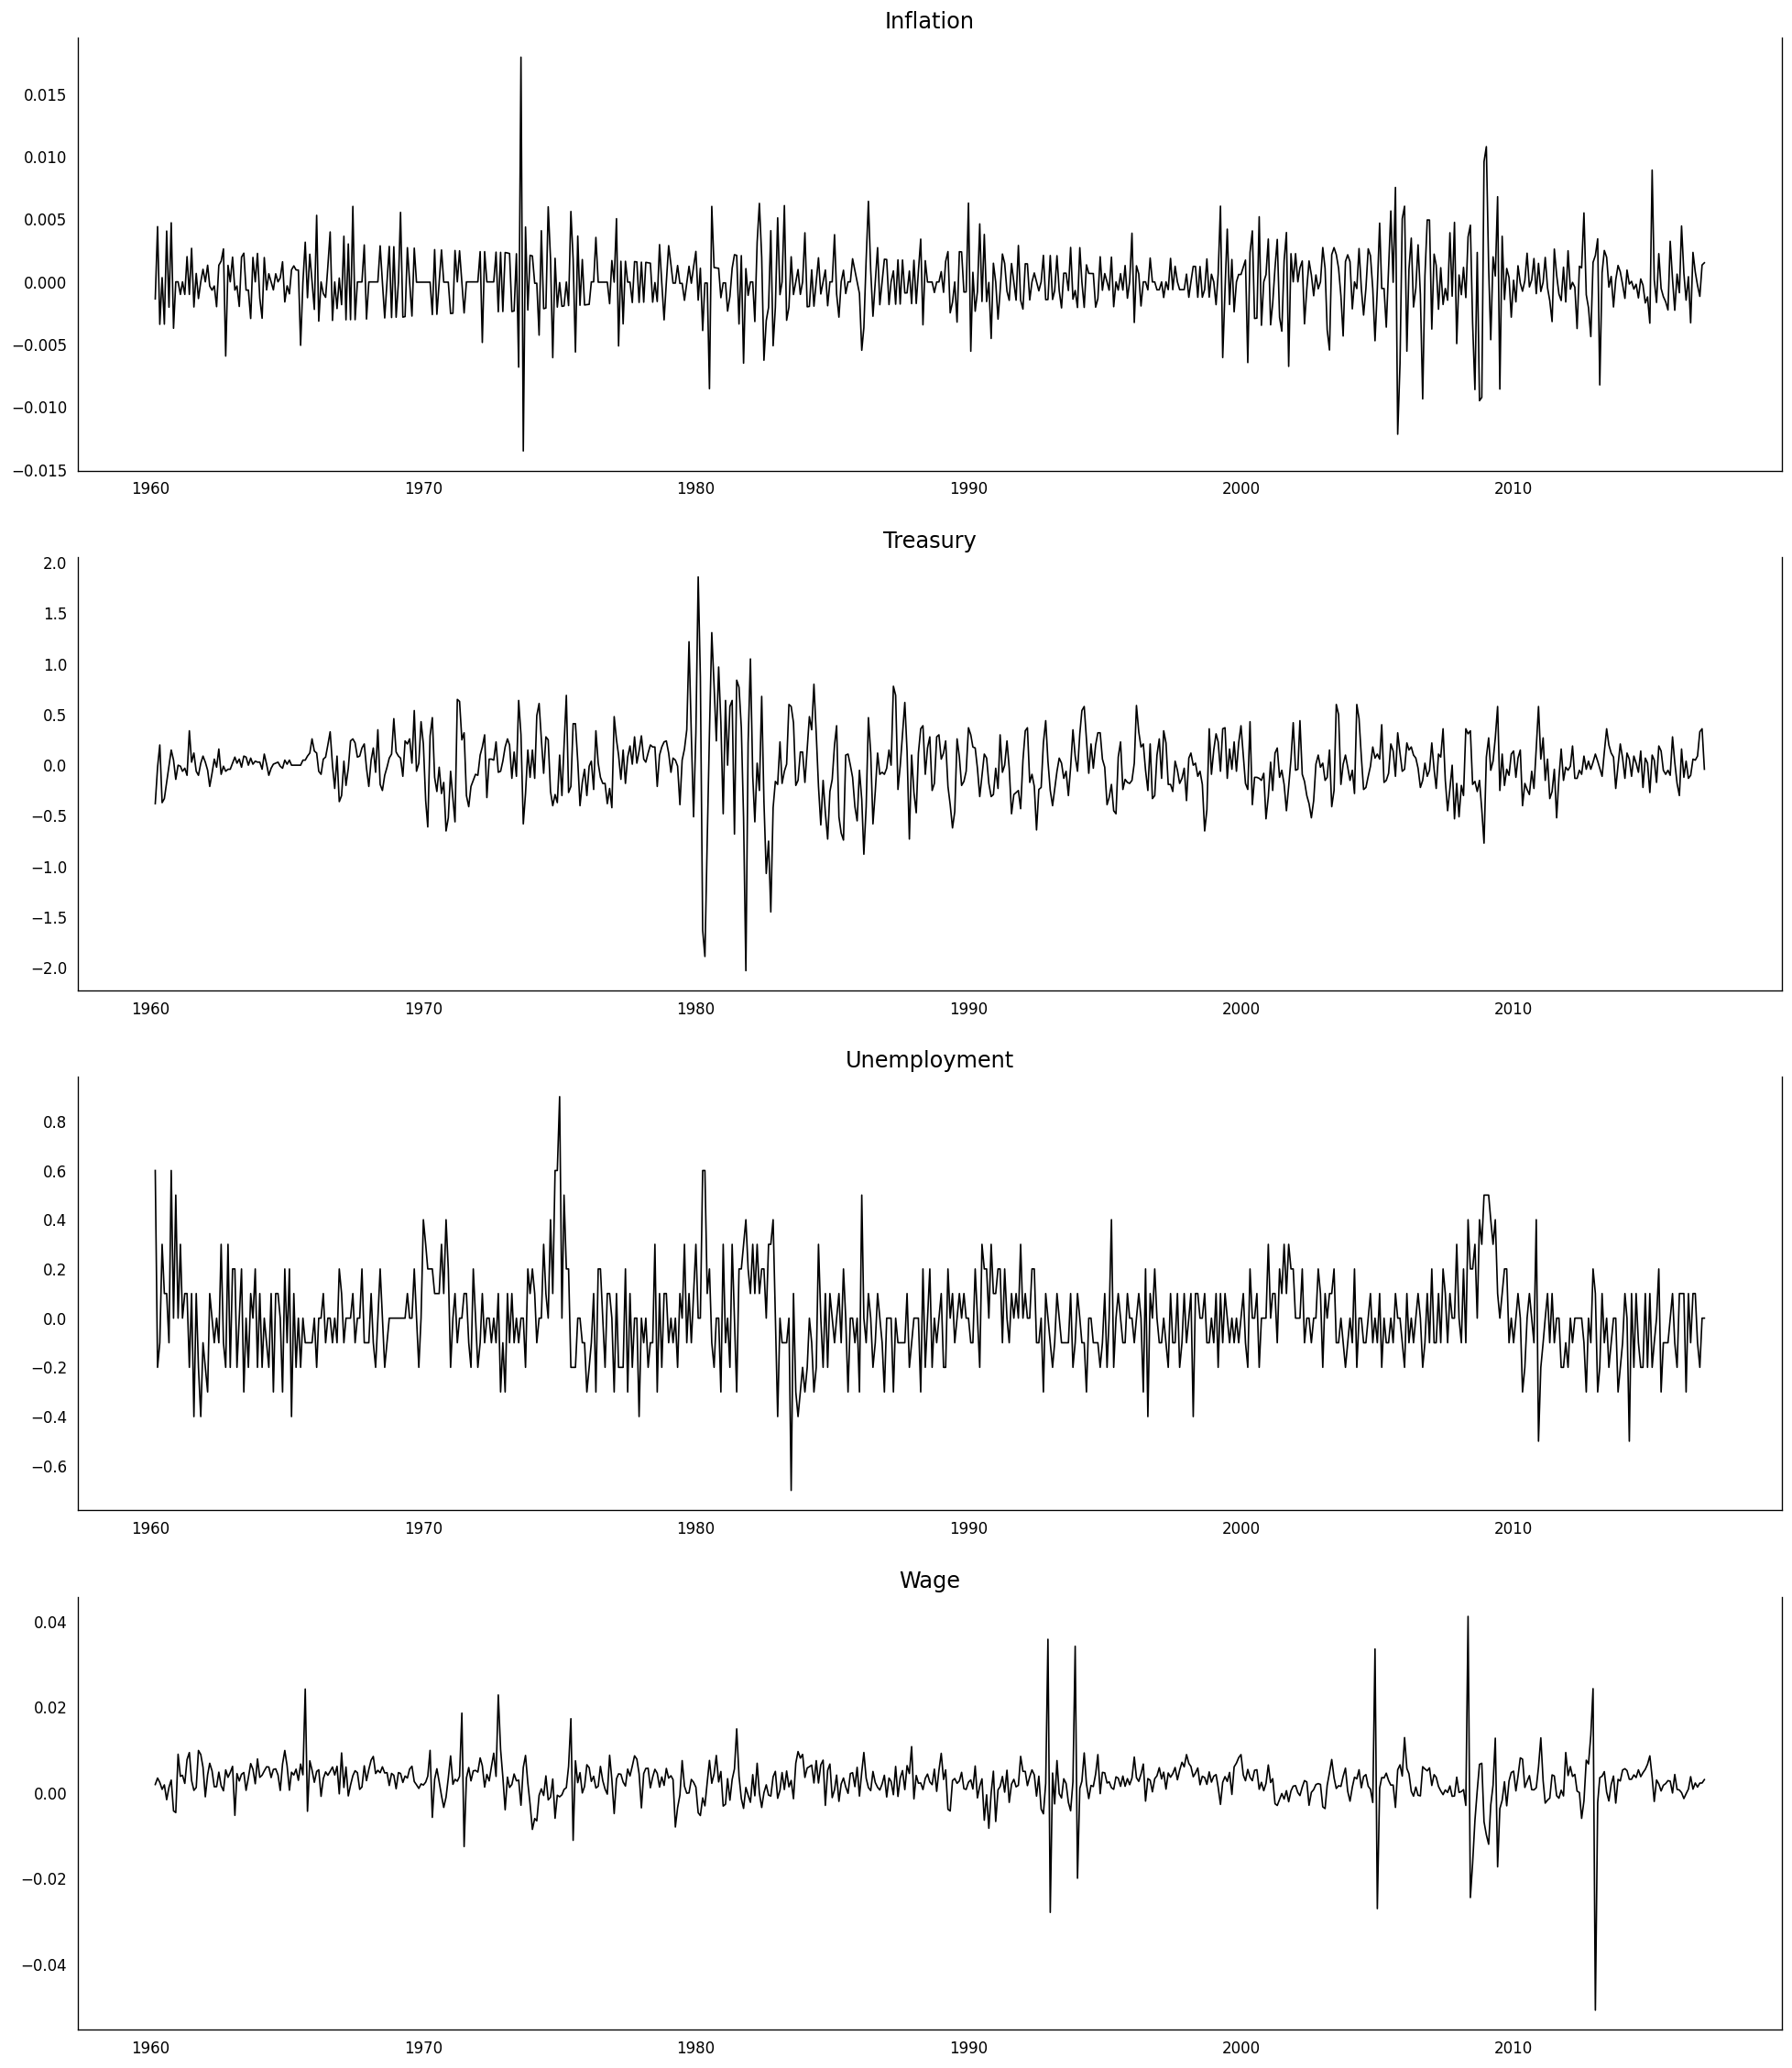

In [5]:
plot_variables(var_dataset)

# Neural Network

In [6]:
model_name = get_best_model_name(end_year, variable, output_steps)
model = keras.models.load_model(os.path.join(MODELS_PATH,model_name))

In [7]:
model_details = get_model_details(end_year, variable, output_steps)
look_back_steps = int(model_details['look_back_years']*12)
number_of_pca = model_details['number_of_pca']

In [8]:
model_details['model_parameters']

{'learning_rate': 0.001,
 'CNN_layers': 2,
 'LSTM_layers': 0,
 'Dense_layers': 1,
 'Dropout_prob': 0.2,
 'CNN_0_filters': 64,
 'LSTM_0_units': 128,
 'Dense_0_units': 128,
 'LSTM_1_units': 96,
 'Dense_1_units': 64,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0,
 'CNN_1_filters': 32}

In [9]:
data_prep.transform_to_supervised_learning(NA_CUTOFF, [variable], output_steps, start = f'{START_YEAR}-01-01', end = f'{end_year}-01-01')
dataset = data_prep.supervised_dataset
full_dataset = dataset['transformed_data']

In [10]:
data = prepare_model_data(window = full_dataset, X_variables = dataset['X_variables'], 
                Y_variables = dataset['Y_variables'], val_steps = VAL_STEPS, look_back = look_back_steps,
                test_steps = TEST_STEPS, remove_outlier = REMOVE_OUTLIER, number_of_pca = number_of_pca,
                target_variables = dataset['target_variables'])

data['train_X'] = data['train_X'][len(data['train_X'])%BATCH_SIZE:]
data['train_Y'] = data['train_Y'][len(data['train_Y'])%BATCH_SIZE:]

In [11]:
NN_results = get_NN_results(model, data, VAL_STEPS, TEST_STEPS, look_back_steps, dataset,  BATCH_SIZE, EPOCHS, executions = 5)

Fitting: 1
Fitting: 2
Fitting: 3
Fitting: 4
Fitting: 5


# Compare Results

In [12]:
val_result = {k:v/Var_results['val']['error'][k] for k,v in NN_results['val']['error'].items()}
val_result['average'] = sum(val_result.values())/len(val_result.values())
val_result_raw = {k:v/Var_results['val']['error_raw'][k] for k,v in NN_results['val']['error_raw'].items()}
val_result

{'UNRATE': 0.5312822991488734, 'average': 0.5312822991488734}

In [13]:
test_result = {k:v/Var_results['test']['error'][k] for k,v in NN_results['test']['error'].items()}
test_result['average'] = sum(test_result.values())/len(test_result.values())
test_result_raw = {k:v/Var_results['test']['error_raw'][k] for k,v in NN_results['test']['error_raw'].items()}
test_result

{'UNRATE': 0.9268270714410244, 'average': 0.9268270714410244}

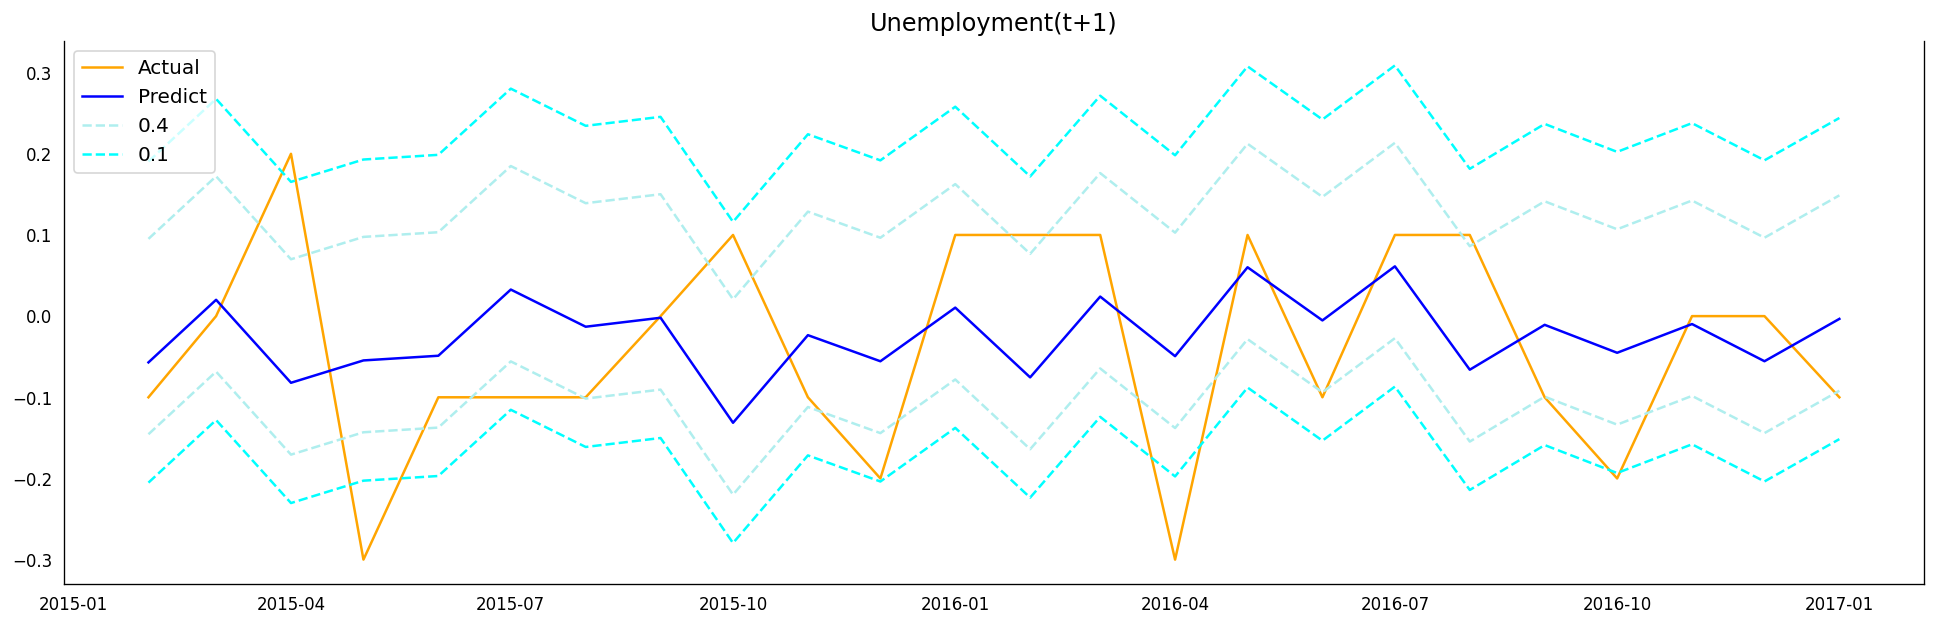

In [14]:
intervals = get_prediction_intervals(NN_results)
plot_results(result = NN_results, period = 'test', target_variable = variable, show_interval = True, intervals = intervals)

In [15]:
import shap

In [21]:
shap.DeepExplainer(NN_results.test_models[0], NN_results.data.train)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [22]:
print("SHAP version is:", shap.__version__)
print("Tensorflow version is:", tf.__version__)

SHAP version is: 0.40.0


NameError: name 'tf' is not defined